In [36]:
import sqlite3
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

## Creating the Database Structure

### Tables:
**team**(<u>teamID</u>, name, city)

**player**(<u>name, team, number</u>, position)

**coach**(<u>team</u>, name, nationality)

**stadium**(<u>home_team</u>, name, city, surface_type, capacity)

**match**(<u>date, home_team, away_team</u>, stadium, home_team_score, away_team_score)

In [2]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()

In [3]:
# create team table
cursor.execute('''create table team(
                teamID text,
                name text,
                city text,
                primary key (teamID))''')

OperationalError: table team already exists

In [12]:
# create player table
cursor.execute('''create table player(
                name text,
                team text,
                number int,
                position text,
                primary key (name, team, number),
                foreign key (team) references team(teamID))''')

In [13]:
# create coach table
cursor.execute('''create table coach(
                name text,
                team text,
                nationality text,
                primary key (team),
                foreign key (team) references team(teamID))''')

In [14]:
# create stadium table
cursor.execute('''create table stadium(
                name text,
                city text,
                home_team text,
                surface_type text,
                capacity int,
                primary key (home_team),
                foreign key (home_team) references team(teamID))''')

In [15]:
# create match table
cursor.execute('''create table match(
                home_team text,
                away_team text,
                date date,
                home_team_score int,
                away_team_score int,
                attendance int,
                primary key (date, home_team, away_team),
                foreign key (home_team) references stadium(home_team),
                foreign key (away_team) references team(teamID))''')

In [16]:
# create commits_foul relation table
cursor.execute('''create table commits_foul(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                card text,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

In [17]:
# create scores_goal relation table
cursor.execute('''create table scores_goal(
                player text,
                number int,
                team text,
                match_date date,
                home_team text,
                away_team text,
                time int,
                primary key (time, match_date, home_team, away_team),
                foreign key (player, number, team) references player(name, number, team),
                foreign key (match_date, home_team, away_team) references match(date, home_team, away_team))''')

## Input data into database
### Web scraping

In [18]:
# scrape list of teams from MLS website, with links to rosters and team info

import requests
from bs4 import BeautifulSoup
import pandas as pd

clublist_url = "https://www.mlssoccer.com/clubs/"
clublist = requests.get(clublist_url)
clublist_soup = BeautifulSoup(clublist.content, 'html5lib')

In [ ]:
# collect data for players in a dataframe

playerdata = pd.DataFrame(columns = ["Name", "Team", "Number", "Position"])
club_names = []
club_ids = []
import json

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-name'}):
    club_names.append(element.contents[1].contents[0])

for element in clublist_soup.find_all('div', {'class': 'mls-o-clubs-hub-clubs-list__club-links'}):
    roster_url = "https://www.mlssoccer.com" + element.contents[1].attrs['href'] + "roster/"
    roster = requests.get(roster_url)
    roster_soup = BeautifulSoup(roster.content, 'html5lib')
    
    for element in roster_soup.find_all('section', {'class': "mls-l-module mls-l-module--active-roster"}):
        club_info = json.loads(element["data-options"])
        for player in club_info["playersData"]:
            name = player["fullName"]
            team = club_info["clubAbbreviation"]
            number = player["jerseyNumber"]
            position = player["position"]
            playerdata = playerdata.append(pd.DataFrame([[name, team, number, position]], columns = ["Name", "Team", "Number", "Position"]))
            
    club_ids.append(club_info["clubAbbreviation"])
        
playerdata.reset_index(inplace=True)

In [ ]:
# use dataframe to populate database

for i in range(len(playerdata)):
    if i == 510: # there is a duplicate value in this row
        continue
    sql = '''insert into player
             (name, team, number, position)
             values
             (:name, :team, :number, :position)'''
    cursor.execute(sql, {'name':playerdata["Name"][i], 'team':playerdata["Team"][i], 'number':playerdata["Number"][i], 'position':playerdata["Position"][i]})
    
    conn.commit()

In [ ]:
# manually create list of home cities (not easily accessible on MLS website)

cities = ["Atlanta", "Austin", "Chicago", "Cincinnati", "Denver", "Columbus", "Washington", "Dallas", "Houston", "Kansas City", "Los Angeles", "Los Angeles", "Miami", "Saint Paul", "Montreal", "Nashville", "Boston", "New York", "New York", "Orlando", "Philadelphia", "Portland", "Salt Lake City", "San Jose", "Seattle", "Toronto", "Vancouver"]

In [ ]:
# create dataframe of team data using data collected during last step

teamdata = pd.DataFrame()
teamdata["TeamID"] = club_ids
teamdata["Name"] = club_names
teamdata["City"] = cities

In [ ]:
# use dataframe to populate database

for i in range(len(teamdata)):
    sql = '''insert into team
             (teamID, name, city)
             values
             (:teamID, :name, :city)'''
    cursor.execute(sql, {'teamID':teamdata["TeamID"][i], 'name':teamdata["Name"][i], 'city':teamdata["City"][i]})
    
    conn.commit()

In [ ]:
# scrape list of stadiums from Wikipedia

stadium_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_stadiums"
stadium = requests.get(stadium_url)
stadium_soup = BeautifulSoup(stadium.content, 'html5lib')

In [ ]:
# Collect stadium data in a dataframe

stadiumdata = pd.DataFrame(columns = ["name", "home_team", "city", "surface_type", "capacity"])

tr_list = stadium_soup.find_all('table')[1].find_all('tr')
for i in range(1,len(tr_list)):
    name = tr_list[i].contents[3].contents[0].contents[0]
    home_team = tr_list[i].contents[5].contents[0].string
    city = tr_list[i].contents[7].contents[0].contents[0].split(",")[0]
    surface_type = tr_list[i].contents[15].contents[0].string
    capacity = tr_list[i].contents[11].contents[0]
    
    stadiumdata = stadiumdata.append(pd.DataFrame([[name, home_team, city, surface_type, capacity]], columns = ["name", "home_team", "city", "surface_type", "capacity"]))
    
stadiumdata.reset_index(inplace=True, drop=True)  

In [ ]:
# Create a dictionary to convert full team name to team ID 
# (this teamID is abbreviation used as primary key in post tables)

teamname_abbrev = {}
for i in range(len(teamdata)):
    teamname_abbrev[teamdata["Name"][i]] = teamdata["TeamID"][i]
# some team name styles differ; add manually
teamname_abbrev["Minnesota United FC"] = "MIN"
teamname_abbrev["Los Angeles FC"] = "LAFC"
teamname_abbrev["Orlando City SC"] = "ORL"
teamname_abbrev["Atlanta United FC"] = "ATL"
teamname_abbrev["CF Montréal"] = "MTL"

# Use dataframe and dictionary to populate dataframe

for i in range(len(stadiumdata)):
    sql = '''insert into stadium
             (name, home_team, city, surface_type, capacity)
             values
             (:name, :home_team, :city, :surface_type, :capacity)'''
    cursor.execute(sql, {'name':stadiumdata["name"][i], 'home_team':teamname_abbrev[stadiumdata["home_team"][i]], 'city':stadiumdata["city"][i], 'surface_type':stadiumdata["surface_type"][i], 'capacity':stadiumdata["capacity"][i]})
    
    conn.commit()

In [ ]:
# Scrape coach data from Wikipedia

coaches_url = "https://en.wikipedia.org/wiki/List_of_Major_League_Soccer_coaches"
coaches = requests.get(coaches_url)
coaches_soup = BeautifulSoup(coaches.content, 'html5lib')

In [ ]:
# Collect coach data in a dataframe

coachlist = coaches_soup.find_all('table')[0].find_all('tr')

coachdata = pd.DataFrame(columns = ["name", "team", "nationality"])

for i in range(1,len(coachlist)):
    name = coachlist[i].contents[1].string
    nationality = coachlist[i].contents[3].contents[1].string
    team = coachlist[i].contents[7].string
    
    coachdata = coachdata.append(pd.DataFrame([[name, team, nationality]], columns = ["name", "team", "nationality"]))

coachdata.reset_index(inplace=True, drop=True)   

In [ ]:
# Use dataframe and dictionary to populate database

for i in range(len(coachdata)):
    sql = '''insert into coach
             (name, team, nationality)
             values
             (:name, :team, :nationality)'''
    cursor.execute(sql, {'name':coachdata["name"][i], 'team':teamname_abbrev[coachdata["team"][i]], 'nationality':coachdata["nationality"][i]})
    
    conn.commit()

### Manual Entry

We have been unable to find an adequate source from which to scrape data about individual matches, so this data will be input manually using DB Browser.

## Queries

Question ideas:
team records


In [4]:
#cursor.close()

In [6]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()

# Create a SQL statement to print out all the students in the database
# This query is a basic SELECT statement operating on the students table
sql = "SELECT * FROM students"

for row in cursor.execute('SELECT stadium.capacity, stadium.city, stadium.home_team, stadium.name, stadium.surface_type, team.name FROM stadium INNER JOIN team ON stadium.home_team = team.teamID ORDER BY stadium.capacity DESC LIMIT 3'):
        print(row)
    
# Use the cursor to close the connection to the database, now that we're done.
cursor.close()

('N/A', 'Nashville', 'NSH', 'Nissan Stadium', 'Grass', 'Nashville SC')
('42,500', 'Atlanta', 'ATL', 'Mercedes-Benz Stadium', 'FieldTurf', 'Atlanta United')
('37,722', 'Seattle', 'SEA', 'Lumen Field', 'FieldTurf', 'Seattle Sounders FC')


In [ ]:
# Attendance
SELECT *
FROM team, match
WHERE date BETWEEN 2020-02-29 AND 2020-02-30
ORDER BY attendance DESC

# American coachs' players
SELECT coach.name AS coach_name, coach.team, player.name AS player_name, player.number
FROM coach
INNER JOIN player ON player.team = coach.team
WHERE coach.nationality = 'United States'

# Top 3 largest stadiums
SELECT stadium.capacity, stadium.city, stadium.home_team, stadium.name, stadium.surface_type, team.name
FROM stadium
INNER JOIN team ON stadium.home_team = team.teamID
ORDER BY stadium.capacity DESC
LIMIT 3

# best players' coaches?


# best home team scores by turf type?







Rehan Queries Below

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
conn = sqlite3.connect('soccer.db')
cursor = conn.cursor()

#List all the players on the Philadelphia Union Roster
Q1 = "SELECT player.name, player.position,player.team, team.name FROM player INNER JOIN team ON team.teamID = player.team WHERE team = 'PHI'"
resultQ1 = cursor.execute(Q1)
all_players_philly = resultQ1.fetchall()

philly_team_df = pd.DataFrame(all_players_philly,columns = ['Name','Position','Team','Team Name'])
print(philly_team_df)
        

                         Name    Position Team           Team Name
0                  Leon Flach  Midfielder  PHI  Philadelphia Union
1              Stuart Findlay    Defender  PHI  Philadelphia Union
2                Jack Elliott    Defender  PHI  Philadelphia Union
3              Quinn Sullivan  Midfielder  PHI  Philadelphia Union
4              Nathan Harriel    Defender  PHI  Philadelphia Union
5             Paxten Aaronson  Midfielder  PHI  Philadelphia Union
6               Brandan Craig  Midfielder  PHI  Philadelphia Union
7                Jack McGlynn  Midfielder  PHI  Philadelphia Union
8               Jakob Glesnes    Defender  PHI  Philadelphia Union
9                Matej Oravec  Midfielder  PHI  Philadelphia Union
10              José Martínez  Midfielder  PHI  Philadelphia Union
11                Cole Turner  Midfielder  PHI  Philadelphia Union
12              Jack De Vries  Midfielder  PHI  Philadelphia Union
13            Jamiro Monteiro  Midfielder  PHI  Philadelphia U

                 Team Name Team  # of goals
0           Atlanta United  ATL           2
1          Colorado Rapids  COL           2
2                FC Dallas  DAL           2
3              D.C. United   DC           1
4        Houston Dynamo FC  HOU           1
5                LA Galaxy   LA           1
6              CF Montréal  MTL           2
7   New England Revolution   NE           1
8             Nashville SC  NSH           1
9     San Jose Earthquakes   SJ           2
10    Sporting Kansas City  SKC           3
11              Toronto FC  TOR           2
12  Vancouver Whitecaps FC  VAN           1


<AxesSubplot:title={'center':'Number of Goals Scored by Team'}, xlabel='Team'>

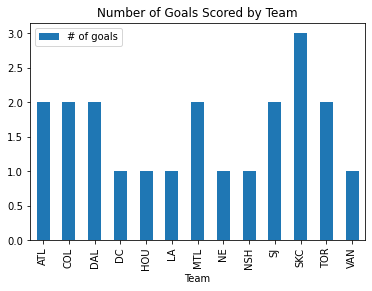

In [40]:
#Which team has score the most number of goals? How does that compare to the rest of the league?
Q2 = "SELECT team.name, scores_goal.team, count(scores_goal.team)FROM scores_goal INNER JOIN team WHERE scores_goal.team = team.teamID GROUP By team.teamID"
resultQ2 = cursor.execute(Q2)
team_goals = resultQ2.fetchall()
    
team_goals_df = pd.DataFrame(team_goals,columns = ['Team Name','Team','# of goals'])
print(team_goals_df)
team_goals_df.plot.bar(x='Team',y='# of goals', title = 'Number of Goals Scored by Team')

In [44]:
# Who has committed a foul for DC United? 
Q3 = "SELECT commits_foul.player, commits_foul.team, count(commits_foul.player),commits_foul.card FROM commits_foul WHERE commits_foul.team = 'DC' GROUP By commits_foul.player"
resultQ3 = cursor.execute(Q3)
dc_penalties = resultQ2.fetchall()

dc_penalty_df = pd.DataFrame(dc_penalties,columns = ['Name','Team','# of Penalties','Card Color'])
print(dc_penalty_df)


                Name Team  # of Penalties Card Color
0  Frédéric Brillant   DC               1          Y
1        Joseph Mora   DC               1          Y
2      Júnior Moreno   DC               1          Y


In [47]:
cursor.close()